In [1]:
import numpy as np
import math
import random
import json
import h5py

import tensorflow as tf
import keras
import keras.backend as K

import matplotlib.pyplot as plt

### Tryout backdoored model

In [2]:
clean_data_filename = "original_data/lab3/data/cl/valid.h5"
poisoned_data_filename = "original_data/lab3/data/bd/bd_valid.h5"
model_filename = "original_data/lab3/models/bd_net.h5"

In [3]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [4]:
cl_x_val, cl_y_val = data_loader(clean_data_filename)
bd_x_val, bd_y_val = data_loader(poisoned_data_filename)

bd_model = keras.models.load_model(model_filename)

cl_label_p = np.argmax(bd_model.predict(cl_x_val), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_val))*100
print('Clean Classification accuracy:', clean_accuracy)

bd_label_p = np.argmax(bd_model.predict(bd_x_val), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_val))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


### Pruning defense

In [5]:
feature_net = keras.Model(inputs=bd_model.input, outputs=bd_model.layers[6].output)
interpretation_net = keras.Model(inputs=bd_model.layers[7].input, outputs=bd_model.output)
activations = feature_net.predict(cl_x_val)

In [6]:
average_activation = np.mean(activations, axis=0)
idx = np.unravel_index(np.argsort(average_activation, axis=None), average_activation.shape)

In [7]:
def Pruned_Net(custom_mask=None):
    mask = tf.Variable(custom_mask, trainable=False, dtype=tf.float32)
    masked = keras.layers.Lambda(lambda x: x * mask)(feature_net.output)
    return keras.Model(inputs=feature_net.output, outputs=interpretation_net(masked))

In [8]:
prune_mask = np.ones((5, 4, 60))
stored_masks = {2: None, 4: None, 10: None, 30: None}
for i in range(5 * 4 * 60):
    prune_mask[idx[0][i], idx[1][i], idx[2][i]] = 0
    if i <= 900:
        continue # to save time
    pruned_net = Pruned_Net(prune_mask)

    label_pruned = np.argmax(pruned_net.predict(activations), axis=1)
    accuracy_pruned = np.mean(np.equal(label_pruned, cl_y_val))*100

    if i % 20 == 0:
        print("Step {}: current acc {}, {} reduced".format(i, accuracy_pruned, clean_accuracy - accuracy_pruned))

    if stored_masks[2] is None and accuracy_pruned <= clean_accuracy - 2:
        stored_masks[2] = prune_mask.copy()
    if stored_masks[4] is None and accuracy_pruned <= clean_accuracy - 4:
        stored_masks[4] = prune_mask.copy()
    if stored_masks[10] is None and accuracy_pruned <= clean_accuracy - 10:
        stored_masks[10] = prune_mask.copy()
    if stored_masks[30] is None and accuracy_pruned <= clean_accuracy - 30:
        stored_masks[30] = prune_mask.copy()
    
    if stored_masks[2] is not None and stored_masks[4] is not None and stored_masks[10] is not None and stored_masks[30] is not None:
        break

Step 920: current acc 97.05551225426518, 1.5934874859270707 reduced
Step 940: current acc 95.88637741404695, 2.762622326145305 reduced
Step 960: current acc 94.8038451545856, 3.8451545856066502 reduced
Step 980: current acc 93.6087295401403, 5.04027020005195 reduced
Step 1000: current acc 91.82471637654803, 6.824283363644227 reduced
Step 1020: current acc 89.35654282497619, 9.292456915216064 reduced
Step 1040: current acc 82.28111197713692, 16.367887763055336 reduced
Step 1060: current acc 68.90101325019485, 29.747986489997402 reduced


In [9]:
np.save("models/mask_2.npy", stored_masks[2])
np.save("models/mask_4.npy", stored_masks[4])
np.save("models/mask_10.npy", stored_masks[10])
np.save("models/mask_30.npy", stored_masks[30])

In [10]:
cl_x_test, cl_y_test = data_loader("original_data/lab3/data/cl/test.h5")
bd_x_test, bd_y_test = data_loader("original_data/lab3/data/bd/bd_test.h5")

In [11]:
pruned_net = Pruned_Net(stored_masks[2])

activations = feature_net.predict(cl_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
cl_label_p = np.where(y_1 == y_2, y_1, 1283)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

activations = feature_net.predict(bd_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
bd_label_p = np.where(y_1 == y_2, y_1, 1283)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 96.58612626656274
Attack Success Rate: 99.99220576773187


In [12]:
pruned_net = Pruned_Net(stored_masks[4])

activations = feature_net.predict(cl_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
cl_label_p = np.where(y_1 == y_2, y_1, 1283)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

activations = feature_net.predict(bd_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
bd_label_p = np.where(y_1 == y_2, y_1, 1283)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 94.77786438035854
Attack Success Rate: 98.46453624318005


In [13]:
pruned_net = Pruned_Net(stored_masks[10])

activations = feature_net.predict(cl_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
cl_label_p = np.where(y_1 == y_2, y_1, 1283)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

activations = feature_net.predict(bd_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
bd_label_p = np.where(y_1 == y_2, y_1, 1283)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 88.09041309431022
Attack Success Rate: 63.16445830085736


In [14]:
pruned_net = Pruned_Net(stored_masks[30])

activations = feature_net.predict(cl_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
cl_label_p = np.where(y_1 == y_2, y_1, 1283)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

activations = feature_net.predict(bd_x_test)
y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
y_2 = np.argmax(pruned_net.predict(activations), axis=1)
bd_label_p = np.where(y_1 == y_2, y_1, 1283)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 67.8332034294622
Attack Success Rate: 81.60561184723305


### Plot

In [15]:
cl_label_p = np.argmax(bd_model.predict(cl_x_val), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_val))*100
print('Clean Classification accuracy:', clean_accuracy)

val_activations = feature_net.predict(cl_x_val)
average_activation = np.mean(val_activations, axis=0)
idx = np.unravel_index(np.argsort(average_activation, axis=None), average_activation.shape)

prune_mask = np.ones((5, 4, 60))
prune_percentage = []
acc = []
asr = []

for i in range(5 * 4 * 60):
    prune_mask[idx[0][i], idx[1][i], idx[2][i]] = 0
    if i % 24 == 0:
        pruned_net = Pruned_Net(prune_mask)

        prune_percentage.append((i + 1) / (5 * 4 * 60))

        activations = feature_net.predict(cl_x_test)
        y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
        y_2 = np.argmax(pruned_net.predict(activations), axis=1)
        cl_label_p = np.where(y_1 == y_2, y_1, 1283)
        acc.append(np.mean(np.equal(cl_label_p, cl_y_test))*100)

        activations = feature_net.predict(bd_x_test)
        y_1 = np.argmax(interpretation_net.predict(activations), axis=1)
        y_2 = np.argmax(pruned_net.predict(activations), axis=1)
        bd_label_p = np.where(y_1 == y_2, y_1, 1283)
        asr.append(np.mean(np.equal(bd_label_p, bd_y_test))*100)

Clean Classification accuracy: 98.64899974019225


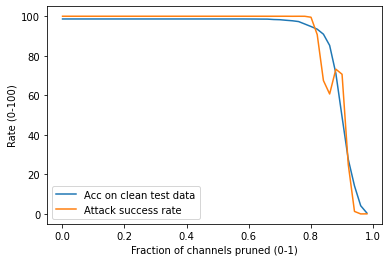

In [17]:
plt.figure()
plt.plot(prune_percentage, acc, label="Acc on clean test data")
plt.plot(prune_percentage, asr, label="Attack success rate")
plt.xlabel("Fraction of channels pruned (0-1)")
plt.ylabel("Rate (0-100)")
plt.legend()
plt.savefig("plot.png")
plt.show()